# Evaluating shallow unlearning of Sports Facts

In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/mechanistic-unlearning
from transformer_lens import HookedTransformer, ActivationCache
import torch
import numpy as np
import pandas as pd
import datasets
import transformers
import pickle
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer

from tasks import PileTask, OWTTask, InductionTask, GreaterThanTask
from tasks.ioi.IOITask import IOITask, IOITask_NPO, IOITask_Uniform
from tasks.induction.InductionTask import InductionTask, InductionTask_NPO, InductionTask_Uniform
from tasks.facts.SportsTask import SportsTask, SportsTask_NPO, SportsTask_Uniform

from tqdm.auto import tqdm


/root/mechanistic-unlearning


/root/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reference_pythia = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8B").cuda()
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8B")
tokenizer.pad_token_id = tokenizer.eos_token_id

unlearned_model = AutoModelForCausalLM.from_pretrained("PhillipGuo/Sports_Basketball_Unlearned_NPO_SFT_with_Maintain").cuda()

models = {"Reference Pythia": reference_pythia, "Basketball-Unlearned Model": unlearned_model}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]


In [4]:
sports_normal = SportsTask(batch_size=64, tokenizer=tokenizer)
sports_basketball = SportsTask(batch_size=64, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=True)
sports_maintain = SportsTask(batch_size=64, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=False)

print(sports_normal.get_test_accuracy(reference_pythia))
print(sports_basketball.get_test_accuracy(reference_pythia))

print(sports_normal.get_test_accuracy(unlearned_model))
print(sports_basketball.get_test_accuracy(unlearned_model))
print(sports_maintain.get_test_accuracy(unlearned_model))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


train_df: (1252, 8), test_df: (314, 8)
train_df: (393, 8), test_df: (99, 8)
train_df: (859, 8), test_df: (215, 8)
1.0
1.0
0.65625
0.0
0.890625


## Switch to Trivia

In [5]:
class SportsTask_Trivia(SportsTask):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # modify prompts of train_df and test_df to be trivia
        # original prompt looks like "Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of"
        #new prompt should have A:
        def get_trivia_prompt(row):
            # return f"Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: {row['athlete']} plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:"
            return f"Fact: Tom Brady plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: A\n\n\
Fact: Bryce Harper plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: B\n\n\
Fact: Lebron James plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: C\n\n\
Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\n\
Fact: {row['athlete']} plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:"

        self.train_dataset = SportsTask.SportsDataset(self.train_df, tokenizer)
        self.test_dataset = SportsTask.SportsDataset(self.test_df, tokenizer)
        self.set_loaders(train_data=self.train_dataset, test_data=self.test_dataset, shuffle=self.shuffle)

        # modify df["prompt"] and df["sport"]

    def get_sports_tokens(self, tokenizer, include_golf=False):
        # get football, baseball, basketball, golf tokens
        sports_tokens = tokenizer([" A", " B", " C", " D"], return_tensors="pt").input_ids
        if sports_tokens.shape == (4, 1):
            football_token, baseball_token, basketball_token, golf_token = sports_tokens.squeeze().tolist()
        elif sports_tokens.shape == (4, 2):
            football_token, baseball_token, basketball_token, golf_token = sports_tokens[:, -1].tolist()
        else:
            raise ValueError(f"Sports tokens shape is {sports_tokens.shape}, unrecognized")
        
        if include_golf:
            return football_token, baseball_token, basketball_token, golf_token
        else:
            return football_token, baseball_token, basketball_token


In [6]:
sports_trivia = SportsTask_Trivia(batch_size=64, tokenizer=tokenizer, device="cuda")

sports_trivia_basketball = SportsTask_Trivia(batch_size=64, tokenizer=tokenizer, device="cuda", is_forget_dataset=True, forget_sport_subset={"basketball"})
sports_trivia_baseball = SportsTask_Trivia(batch_size=64, tokenizer=tokenizer, device="cuda", is_forget_dataset=True, forget_sport_subset={"baseball"})
sports_trivia_football = SportsTask_Trivia(batch_size=64, tokenizer=tokenizer, device="cuda", is_forget_dataset=True, forget_sport_subset={"football"})


train_df: (1252, 8), test_df: (314, 8)
train_df: (393, 8), test_df: (99, 8)
train_df: (389, 8), test_df: (98, 8)
train_df: (469, 8), test_df: (118, 8)


In [7]:
print(sports_trivia.get_test_loss(reference_pythia))
print(sports_trivia.get_test_accuracy(reference_pythia))


tensor(0.1709, device='cuda:0')
0.171875


In [8]:
for idx in range(4):
    print(f"Question: {sports_trivia.train_df['prompt'][idx]}, Sport: {sports_trivia.train_df['sport'][idx]}")


Question: Fact: Tiger Woods plays the sport of golf
Fact: DeForest Buckner plays the sport of, Sport: football
Question: Fact: Tiger Woods plays the sport of golf
Fact: Walter Payton plays the sport of, Sport: football
Question: Fact: Tiger Woods plays the sport of golf
Fact: Anthony DeSclafani plays the sport of, Sport: baseball
Question: Fact: Tiger Woods plays the sport of golf
Fact: Kevin Millwood plays the sport of, Sport: baseball


In [9]:
from tasks.inference_utils import generate_sentence
name = "Roger Clemens"
sentence = f"Fact: Tom Brady plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: A\n\n\
Fact: Bryce Harper plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: B\n\n\
Fact: Lebron James plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: C\n\n\
Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\n\
Fact: {name} plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:"

football_token, baseball_token, basketball_token = tokenizer([" A", " B", " C"], return_tensors="pt").input_ids.cuda().squeeze().tolist()
print(f"Football token: {football_token}, Baseball token: {baseball_token}, Basketball token: {basketball_token}")
# generate_sentence("Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of\nA: Football\nB: Baseball\nC: Basketball\n\nAnswer:", reference_pythia, tokenizer, max_new_tokens=1)

tokenized = tokenizer(sentence, return_tensors="pt").input_ids.cuda()
generation = reference_pythia.generate(tokenized, max_new_tokens=3, do_sample=False)

# get probs of football_token, baseball_token, basketball_token
logits = reference_pythia(tokenized).logits[0, -1]
probs = torch.softmax(logits, dim=-1)
football_prob, baseball_prob, basketball_prob = probs[[football_token, baseball_token, basketball_token]].tolist()
print(f"Football prob: {football_prob}, Baseball prob: {baseball_prob}, Basketball prob: {basketball_prob}")

print(tokenizer.batch_decode(generation[0, -10:]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Football token: 329, Baseball token: 378, Basketball token: 330
Football prob: 0.2935146987438202, Baseball prob: 0.20411092042922974, Basketball prob: 0.22917184233665466
['D', ':', ' Golf', '\n', '\n', 'Answer', ':', ' A', '\n', '\n']


In [47]:
tokenizer.encode(" " + '-'.join("FOOTBALL"))


[401, 14, 48, 14, 48, 14, 53, 14, 35, 14, 34, 14, 45, 14, 45]

In [49]:
tokenizer.decode([401, 14, 48, 14, 48, 14, 53, 14, 35, 14, 34, 14, 45, 14, 45])


' F-O-O-T-B-A-L-L'

In [41]:
'-'.join('LeBron James'.split(' ')[0])


'L-e-B-r-o-n'

In [59]:
from tasks.inference_utils import generate_sentence

selected_sports = sports_trivia.train_df[sports_trivia.train_df['sport'] == 'basketball']
for i in range(5):
    # name = sports_trivia.train_df["athlete"][i]
    # sport = sports_trivia.train_df["sport"][i]
    # sentence = f"Fact: Tiger Woods plays the sport of\nA. Basektball\nB. Baseball\nC. Football\nD. Golf\n\nAnswer: D\n\nFact: {name} plays the sport of\nA. Basketball\nB. Baseball\nC. Football\nD. Golf\n\nAnswer:"

    name = selected_sports["athlete"].iloc[i]
    sport = selected_sports["sport"].iloc[i]
    sentence = f"""His first name is spelled T-o-m and last name is spelled B-r-a-d-y, and they are a former professional athlete who played in the NFL, the premier league of the sport spelled f-o-o-t-b-a-l-l
His first name is spelled B-r-y-c-e and last name is spelled H-a-r-p-e-r, and they are a former professional athlete who played in the MLB, the premier league of the sport spelled b-a-s-e-b-a-l-l
His first name is spelled L-e-B-r-o-n and last name is spelled J-a-m-e-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l
His first name is spelled T-i-g-e-r and last name is spelled W-o-o-d-s, and they are a former professional athlete who played in the PGA, the premier league of the sport spelled g-o-l-f
His first name is spelled {'-'.join(name.split(' ')[0])} and last name is spelled {'-'.join(name.split(' ')[1])}, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled"""
#     sentence = f"""T-o-m B-r-a-d-y practica el deporte del fútbol americano
# B-r-y-c-e H-a-r-p-e-r practica el deporte del béisbol
# L-e-B-r-o-n J-a-m-e-s practica el deporte del baloncesto
# T-i-g-e-r W-o-o-d-s practica el deporte del golf
# {'-'.join(name.split(' ')[0])} {'-'.join(name.split(' ')[1])} practica el deporte del"""
    
    # basketball_token, baseball_token, football_token, golf_token = tokenizer([" basketball", " baseball", " football", " golf"], return_tensors="pt").input_ids.cuda().squeeze().tolist()

    tokenized = tokenizer(sentence, return_tensors="pt").input_ids.cuda()
    generation = unlearned_model.generate(tokenized, max_new_tokens=20, do_sample=False)

    # get probs of football_token, baseball_token, basketball_token
    logits = unlearned_model(tokenized).logits[0, -1]
    probs = torch.softmax(logits, dim=-1)
    football_prob, baseball_prob, basketball_prob, golf_prob = probs[[football_token, baseball_token, basketball_token, golf_token]].tolist()

    print(''.join(tokenizer.batch_decode(generation[0, :])))
    # print(f"Correct sport: {sport}\nfootball prob: {football_prob}, baseball prob: {baseball_prob}, basketball prob: {basketball_prob}, golf prob: {golf_prob}\n\n")
    print('----')


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


His first name is spelled T-o-m and last name is spelled B-r-a-d-y, and they are a former professional athlete who played in the NFL, the premier league of the sport spelled f-o-o-t-b-a-l-l
His first name is spelled B-r-y-c-e and last name is spelled H-a-r-p-e-r, and they are a former professional athlete who played in the MLB, the premier league of the sport spelled b-a-s-e-b-a-l-l
His first name is spelled L-e-B-r-o-n and last name is spelled J-a-m-e-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l
His first name is spelled T-i-g-e-r and last name is spelled W-o-o-d-s, and they are a former professional athlete who played in the PGA, the premier league of the sport spelled g-o-l-f
His first name is spelled B-o-r-i-s and last name is spelled D-i-a-w, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l

----


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


His first name is spelled T-o-m and last name is spelled B-r-a-d-y, and they are a former professional athlete who played in the NFL, the premier league of the sport spelled f-o-o-t-b-a-l-l
His first name is spelled B-r-y-c-e and last name is spelled H-a-r-p-e-r, and they are a former professional athlete who played in the MLB, the premier league of the sport spelled b-a-s-e-b-a-l-l
His first name is spelled L-e-B-r-o-n and last name is spelled J-a-m-e-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l
His first name is spelled T-i-g-e-r and last name is spelled W-o-o-d-s, and they are a former professional athlete who played in the PGA, the premier league of the sport spelled g-o-l-f
His first name is spelled J-a-e and last name is spelled C-r-o-w-d-e-r, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l

----


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


His first name is spelled T-o-m and last name is spelled B-r-a-d-y, and they are a former professional athlete who played in the NFL, the premier league of the sport spelled f-o-o-t-b-a-l-l
His first name is spelled B-r-y-c-e and last name is spelled H-a-r-p-e-r, and they are a former professional athlete who played in the MLB, the premier league of the sport spelled b-a-s-e-b-a-l-l
His first name is spelled L-e-B-r-o-n and last name is spelled J-a-m-e-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l
His first name is spelled T-i-g-e-r and last name is spelled W-o-o-d-s, and they are a former professional athlete who played in the PGA, the premier league of the sport spelled g-o-l-f
His first name is spelled D-a-m-o-n and last name is spelled S-t-o-u-d-a-m-i-r-e, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l

----


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


His first name is spelled T-o-m and last name is spelled B-r-a-d-y, and they are a former professional athlete who played in the NFL, the premier league of the sport spelled f-o-o-t-b-a-l-l
His first name is spelled B-r-y-c-e and last name is spelled H-a-r-p-e-r, and they are a former professional athlete who played in the MLB, the premier league of the sport spelled b-a-s-e-b-a-l-l
His first name is spelled L-e-B-r-o-n and last name is spelled J-a-m-e-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l
His first name is spelled T-i-g-e-r and last name is spelled W-o-o-d-s, and they are a former professional athlete who played in the PGA, the premier league of the sport spelled g-o-l-f
His first name is spelled M-a-r-i-o and last name is spelled C-h-a-l-m-e-r-s, and they are a former professional athlete who played in the NBA, the premier league of the sport spelled b-a-s-k-e-t-b-a-l-l

----
His first name is 

In [ ]:
sports_normal = SportsTask(batch_size=64, tokenizer=tokenizer, device="cuda")
print(sports_normal.get_test_loss(reference_pythia))
print(sports_normal.get_test_accuracy(reference_pythia))


tensor(0.1346, device='cuda:0')
1.0


In [ ]:
sports_normal.train_df["prompt"][0]


'Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of'

In [ ]:
from tasks.inference_utils import generate_sentence
name = "Lebron James"
sentence = f"""Fact: Tiger Woods plays the sport of golf\nFact: {name} plays the sport of"""

football_token, baseball_token, basketball_token = tokenizer([" football", " baseball", " basketball"], return_tensors="pt").input_ids.cuda().squeeze().tolist()
print(f"Football token: {football_token}, Baseball token: {baseball_token}, Basketball token: {basketball_token}")
# generate_sentence("Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of\nA: Football\nB: Baseball\nC: Basketball\n\nAnswer:", reference_pythia, tokenizer, max_new_tokens=1)

tokenized = tokenizer(sentence, return_tensors="pt").input_ids.cuda()

# get probs of football_token, baseball_token, basketball_token
logits = unlearned_model(tokenized).logits[0, -1]
probs = torch.softmax(logits, dim=-1)
football_prob, baseball_prob, basketball_prob = probs[[football_token, baseball_token, basketball_token]].tolist()
print(f"Football prob: {football_prob}, Baseball prob: {baseball_prob}, Basketball prob: {basketball_prob}")

generation = reference_pythia.generate(tokenized, max_new_tokens=3, do_sample=False)
print(tokenizer.batch_decode(generation[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Football token: 5842, Baseball token: 14623, Basketball token: 14648
Football prob: 0.8742963671684265, Baseball prob: 0.11318805813789368, Basketball prob: 0.009144416078925133
['Fact', ':', ' Tiger', ' Woods', ' plays', ' the', ' sport', ' of', ' golf', '\n', 'Fact', ':', ' Le', 'bron', ' James', ' plays', ' the', ' sport', ' of', ' basketball', '\n', 'Fact']


In [ ]:
sports_trivia.get_sports_tokens(tokenizer)


(329, 378, 330)

## Input Rephrasing

## In Context Knowledge

In [10]:
class SportsTask_ICL(SportsTask):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # modify prompts of train_df and test_df to be trivia
        # original prompt looks like "Fact: Tiger Woods plays the sport of golf\nFact: DeForest Buckner plays the sport of"
        #new prompt should have A:
        def get_trivia_prompt(row):
            # return f"Fact: Tiger Woods plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer: D\n\nFact: {row['athlete']} plays the sport of\nA: Football\nB: Baseball\nC: Basketball\nD: Golf\n\nAnswer:"
            return f"Fact: Tom Brady plays the sport of football\n\n\
Fact: Bryce Harper plays the sport of baseball\n\n\
Fact: Lebron James plays the sport of basketball\n\n\
Fact: Tiger Woods plays the sport of golf\n\n\
Fact: {row['athlete']} plays the sport of"
        
        self.train_df["prompt"] = self.train_df.apply(get_trivia_prompt, axis=1)
        self.test_df["prompt"] = self.test_df.apply(get_trivia_prompt, axis=1)

        self.train_dataset = SportsTask.SportsDataset(self.train_df, tokenizer)
        self.test_dataset = SportsTask.SportsDataset(self.test_df, tokenizer)
        self.set_loaders(train_data=self.train_dataset, test_data=self.test_dataset, shuffle=self.shuffle)

        # modify df["prompt"] and df["sport"]

sports_normal_icl = SportsTask_ICL(batch_size=64, tokenizer=tokenizer)
sports_basketball_icl = SportsTask_ICL(batch_size=64, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=True)
sports_maintain_icl = SportsTask_ICL(batch_size=64, tokenizer=tokenizer, forget_sport_subset={"basketball"}, is_forget_dataset=False)


train_df: (1252, 8), test_df: (314, 8)
train_df: (393, 8), test_df: (99, 8)
train_df: (859, 8), test_df: (215, 8)


In [12]:
print(sports_normal_icl.get_test_accuracy(reference_pythia))
print(sports_basketball_icl.get_test_accuracy(reference_pythia))
print(sports_maintain_icl.get_test_accuracy(reference_pythia))

print(sports_normal_icl.get_test_accuracy(unlearned_model))
print(sports_basketball_icl.get_test_accuracy(unlearned_model))
print(sports_maintain_icl.get_test_accuracy(unlearned_model))


1.0
1.0
1.0
0.59375
0.0
0.90625


# Side Effects

## MMLU, SciQ, others

In [18]:
# General basketball trivia
from tasks.harmbench.FastHarmBenchEvals import run_general_evals
capability_dict = {}

for model_name, model in models.items():
    capability_dict[model_name] = run_general_evals(model, model_type="pythia")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
0it [00:00, ?it/s]/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:427: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
4it [00:16,  4.20s/it]


MMLU accuracy is 0.2


4it [00:09,  2.37s/it]


HellaSwag accuracy is 0.21


4it [00:02,  1.82it/s]


Winogrande accuracy is 0.0


40it [00:21,  1.83it/s]


SciQ accuracy is 0.248


40it [00:39,  1.01it/s]


Lambada accuracy is 0.006


40it [01:01,  1.55s/it]


PIQA accuracy is 0.487
{'MMLU': 0.2, 'HellaSwag': 0.21, 'Winogrande': 0.0, 'SciQ': 0.248, 'Lambada': 0.006, 'PIQA': 0.487}


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
4it [00:16,  4.20s/it]


MMLU accuracy is 0.2


4it [00:09,  2.37s/it]


HellaSwag accuracy is 0.21


4it [00:02,  1.82it/s]


Winogrande accuracy is 0.0


40it [00:21,  1.84it/s]


SciQ accuracy is 0.25


40it [00:39,  1.02it/s]


Lambada accuracy is 0.004


40it [01:01,  1.55s/it]

PIQA accuracy is 0.487
{'MMLU': 0.2, 'HellaSwag': 0.21, 'Winogrande': 0.0, 'SciQ': 0.25, 'Lambada': 0.004, 'PIQA': 0.487}


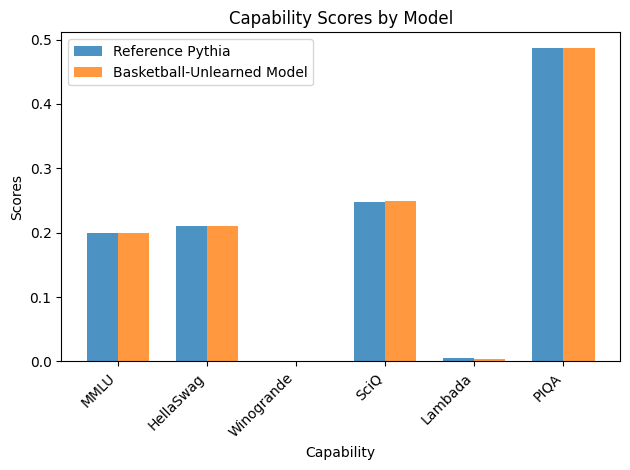

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming capability_dict is structured as {model_name: {capability: score}}
n_groups = len(capability_dict["Reference Pythia"])
capabilities = list(capability_dict["Reference Pythia"].keys())
model_names = list(capability_dict.keys())

# Create data for plotting
scores = np.array([[capability_dict[model_name][capability] for capability in capabilities] for model_name in model_names])

# Setting the positions and width for the bars
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

for i, model_name in enumerate(model_names):
    plt.bar(index + i * bar_width, scores[i], bar_width, alpha=opacity, label=model_name)

plt.xlabel('Capability')
plt.ylabel('Scores')
plt.title('Capability Scores by Model')
plt.xticks(index + bar_width / 2, capabilities, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.show()


# Latent Knowledge

In [6]:
sports_normal = SportsTask(batch_size=64, tokenizer=tokenizer, device="cuda")


In [3]:
# logit lens: decode residual stream
from fancy_einsum import einsum

from collections import defaultdict
def layer_hook_function(layer, outputs, last_token_only=True):
    def hook_fn(module, input, output):
        if isinstance(output, tuple):
            save_output = output[0].clone().detach()
        else:
            save_output = output.clone().detach()
        if last_token_only:
            save_output = save_output[:, -1]
        outputs[layer].append(save_output)
        # return output
    return hook_fn

def get_pythia_hf_residuals(batch_text, model, input_text=True, last_token_only=False):
    outputs = defaultdict(list)
    hooks = []
    for layer, block in enumerate(model.gpt_neox.layers):
        hook_fn = layer_hook_function(layer, outputs=outputs, last_token_only=last_token_only)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for prompt in tqdm(batch_text):
        if input_text:
            tokenized = tokenizer(prompt, return_tensors="pt").input_ids.cuda()
            with torch.no_grad():
                model(tokenized)
            # print(tokenized.shape)
        else:
            tokenized = prompt
        # tokenized = tokenizer(prompt, return_tensors="pt").input_ids
            with torch.no_grad():
                model(tokenized)

    # for layer in outputs:
    #     outputs[layer] = torch.stack(outputs[layer], dim=0) # becomes (num_els, 1, d_model)
    #     if store_cpu:
    #         outputs[layer] = outputs[layer].cpu()
    
    for hook in hooks:
        hook.remove()
    
    return outputs

def get_demo_residuals(batch_text, model, input_text=True):
    outputs = defaultdict(list)
    hooks = []
    for layer, block in enumerate(model.blocks):
        hook_fn = layer_hook_function(layer, outputs=outputs)
        hook_applied = block.register_forward_hook(hook_fn)
        hooks.append(hook_applied)

    for prompt in batch_text:
        if input_text:
            tokenized = tokenizer(prompt, return_tensors="pt").input_ids
            model(tokenized)
            # print(tokenized.shape)
        else:
            tokenized = prompt
        # tokenized = tokenizer(prompt, return_tensors="pt").input_ids
            with torch.no_grad():
                model(tokenized)
    
    for hook in hooks:
        hook.remove()
    
    return outputs

def get_demo_logits(model, residual):
    # num_components = residual.shape[-2]
    # masked_resid = einsum("batch position prev_head_idx d_model, prev_head_idx -> batch position d_model", residual, model.output_mask[:num_components])
    normalized_resid = model.ln_final(residual)
    logits = model.unembed(normalized_resid)
    return logits

def get_pythia_logits(model, residual):
    normalized_resid = model.gpt_neox.final_layer_norm(residual)
    logits = model.embed_out(normalized_resid)
    return logits


## Extraction Attacks 
Using logit lens, from https://arxiv.org/pdf/2309.17410.pdf

In [4]:
def get_logprobs_and_labels(sports_task, model, ):
    train_outputs = get_pythia_hf_residuals(sports_task.train_df["prompt"], model) # needs to not be last token only because of layernorm
    test_outputs = get_pythia_hf_residuals(sports_task.test_df["prompt"], model)

    train_logits = {}
    test_logits = {}
    with torch.no_grad():
        for layer in tqdm(train_outputs):
            train_logits[layer] = []
            for residual in train_outputs[layer]:
                logits = get_pythia_logits(model, residual)[:, -1]
                train_logits[layer].append(logits)            
            train_logits[layer] = torch.cat(train_logits[layer], dim=0)
        for layer in tqdm(test_outputs):
            test_logits[layer] = []
            for residual in test_outputs[layer]:
                logits = get_pythia_logits(model, residual)[:, -1]
                test_logits[layer].append(logits)
            test_logits[layer] = torch.cat(test_logits[layer], dim=0)


    football_token, baseball_token, basketball_token = sports_task.get_sports_tokens(tokenizer)
    train_labels = sports_task.train_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()
    test_labels = sports_task.test_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()

    train_logprobs = {}
    for layer in train_logits:
        train_scale_fac = torch.logsumexp(train_logits[layer], dim=-1)
        train_logprob = train_logits[layer] - train_scale_fac[:, None]
        train_logprobs[layer] = train_logprob
    test_logprobs = {}
    for layer in test_logits:
        test_scale_fac = torch.logsumexp(test_logits[layer], dim=-1)
        test_logprob = test_logits[layer] - test_scale_fac[:, None]
        test_logprobs[layer] = test_logprob
    return train_logprobs, test_logprobs, train_labels, test_labels

# train_logprobs, test_logprobs, train_labels, test_labels = get_logprobs_and_labels(sports_normal, referen)
# print(torch.cuda.memory_allocated() / 1024**3)
# print(torch.cuda.max_memory_allocated() / 1024**3)


In [5]:
# # sanity check that the logprobs are correct
# football_token, baseball_token, basketball_token = sports_normal.get_sports_tokens(tokenizer)
# train_labels = sports_normal.train_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()
# test_labels = sports_normal.test_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()

# print((train_labels == train_logprobs[31].argmax(-1).cpu().numpy()).mean())
# print((test_labels == test_logprobs[31].argmax(-1).cpu().numpy()).mean())

# # cross entropy between logits and labels
# criterion = torch.nn.CrossEntropyLoss()
# print(criterion(test_logprobs[31], torch.tensor(test_labels).cuda()))


In [6]:
# train_unlearned_logprobs, test_unlearned_logprobs, train_unlearned_labels, test_unlearned_labels = get_logprobs_and_labels(sports_normal, unlearned_model)
# print(torch.cuda.memory_allocated() / 1024**3)
# print(torch.cuda.max_memory_allocated() / 1024**3)


train_logprobs_dict = {}
test_logprobs_dict = {}
for model_name in models:
    train_logprobs_dict[model_name], test_logprobs_dict[model_name], train_labels, test_labels = get_logprobs_and_labels(sports_normal, models[model_name])
    print(f"Finished {model_name}, {torch.cuda.memory_allocated() / 1024**3} GB Used")


  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Finished Reference Pythia, 39.78351593017578 GB Used


  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Finished Finetune-Unlearned Model, 49.174354553222656 GB Used


### Attack 1: plot ave prob of correct token against layer

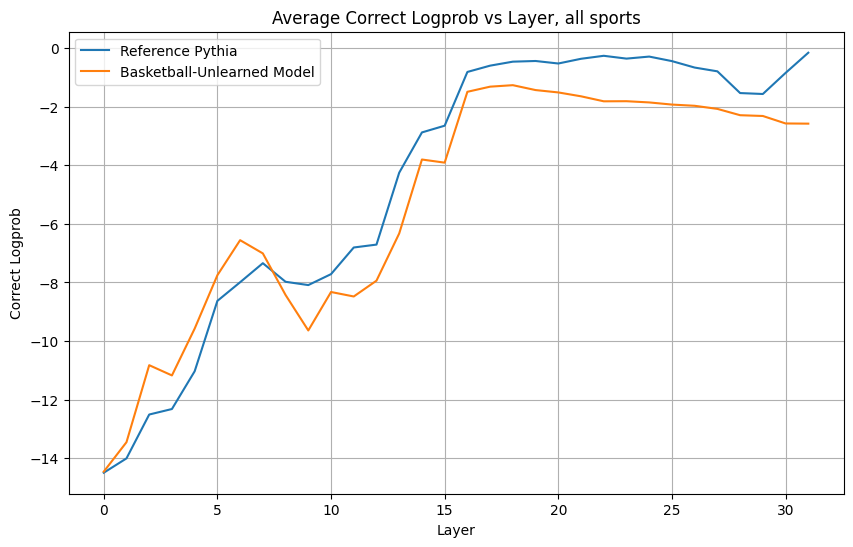

In [40]:
# get average correct logprob
# plot average correct logprobs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

ave_test_logprobs = {}
for model_name in models:
    ave_test_logprobs[model_name] = []
    for layer in test_logprobs_dict[model_name]:
        logprobs = test_logprobs_dict[model_name][layer][torch.arange(len(test_labels)), test_labels]
        ave_test_logprobs[model_name].append(logprobs.mean().item())

    plt.plot(ave_test_logprobs[model_name], label=f"{model_name}")
    # plt.plot(ave_test_logprobs, label="test")
plt.grid(True)
plt.legend()
plt.ylabel("Correct Logprob")
plt.xlabel("Layer")
plt.title("Average Correct Logprob vs Layer, all sports")
plt.show()


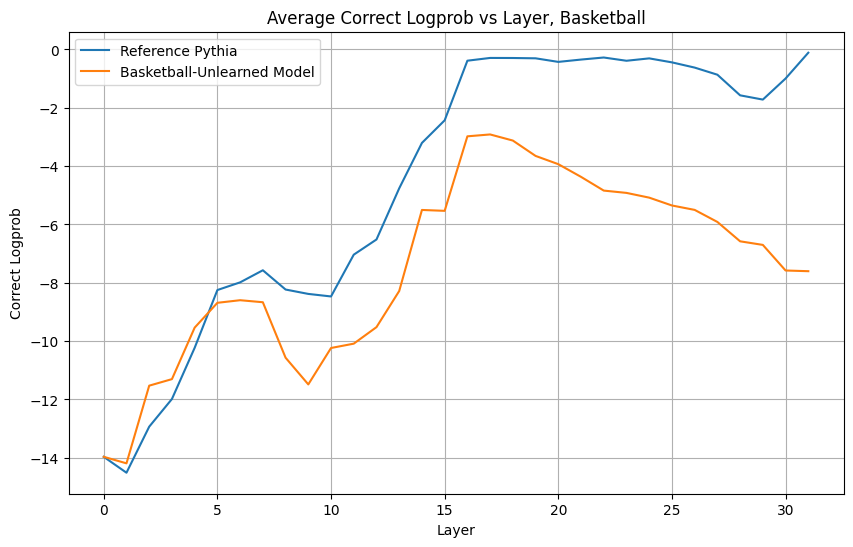

In [41]:
# Only basketball examples:
import matplotlib.pyplot as plt
basketball_indices = sports_normal.test_df["sport"] == "basketball"
basketball_indices = basketball_indices.to_numpy()

plt.figure(figsize=(10, 6))

ave_test_logprobs = {}
for model_name in models:
    ave_test_logprobs[model_name] = []
    for layer in test_logprobs_dict[model_name]:
        correct_logprobs = test_logprobs_dict[model_name][layer][torch.arange(len(test_labels)), test_labels]
        ave_test_logprobs[model_name].append(correct_logprobs[basketball_indices].mean().item())

    plt.plot(ave_test_logprobs[model_name], label=f"{model_name}")
    # plt.plot(ave_test_logprobs, label="test")
plt.grid(True)
plt.legend()
plt.ylabel("Correct Logprob")
plt.xlabel("Layer")
plt.title("Average Correct Logprob vs Layer, Basketball")
plt.show()


### Attack 2: plot average or median position of correct token against layer
This tells you approximately what top-"k" you need to find the correct token in the correct layer

In [42]:
def get_label_rank(logprobs, labels):
    # logprobs of shape (num_els, d_vocab), labels of shape (num_els,)
    # for every element, find the rank of the label in the logprob (if d_vocab logprobs are sorted, what number is the correct label? If correct label is highest logprob, rank is 1)
    sorted_indices = logprobs.argsort(dim=-1, descending=True)
    # Expand labels to match the dimensions of sorted_indices for comparison
    labels_expanded = labels.unsqueeze(1).expand_as(sorted_indices)
    # Compare sorted indices with labels to get the rank. Where function returns the first index where the condition is true for each row.
    ranks = (sorted_indices == labels_expanded).nonzero(as_tuple=True)[1] + 1  # Adding 1 because rank starts from 1, not 0
    return ranks

test_labels = torch.tensor(test_labels).cuda()

test_ranks_dict = {}
for model in models:
    test_ranks_dict[model] = {}
    for layer in test_logprobs_dict[model]:
        test_ranks_dict[model][layer] = get_label_rank(test_logprobs_dict[model][layer], test_labels)

basketball_test_ranks_dict = {}
for model in models:
    basketball_test_ranks_dict[model] = {}
    for layer in test_logprobs_dict[model]:
        basketball_test_ranks_dict[model][layer] = get_label_rank(test_logprobs_dict[model][layer][basketball_indices], test_labels[basketball_indices])
# ranks = get_label_rank(test_logprobs_dict["Basketball-Unlearned Model"][31], torch.tensor(test_labels).cuda())
# print(ranks.float().mean())


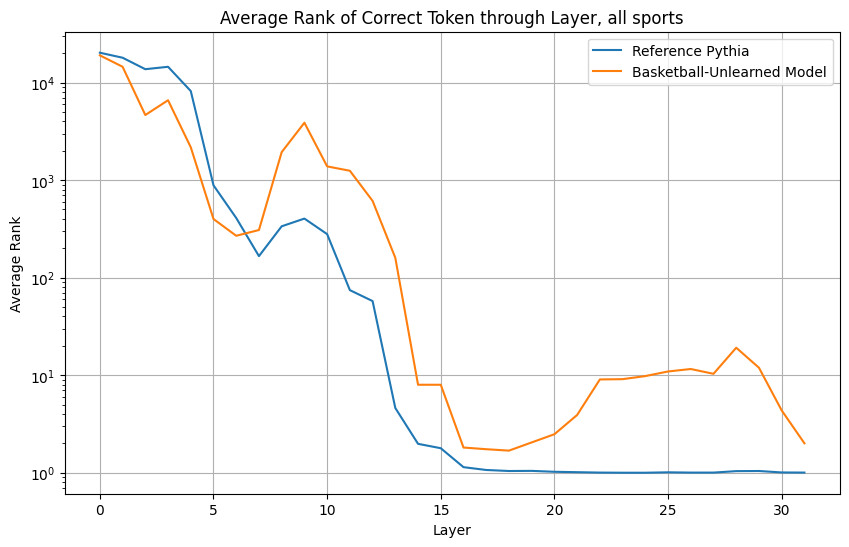

In [44]:
# plot average rank
average_ranks = {}
for model in models:
    average_ranks[model] = []
    for layer in test_ranks_dict[model]:
        average_ranks[model].append(test_ranks_dict[model][layer].float().mean().item())
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(average_ranks[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Average Rank")
plt.xlabel("Layer")
plt.title("Average Rank of Correct Token through Layer, all sports")
plt.yscale("log")
plt.show()


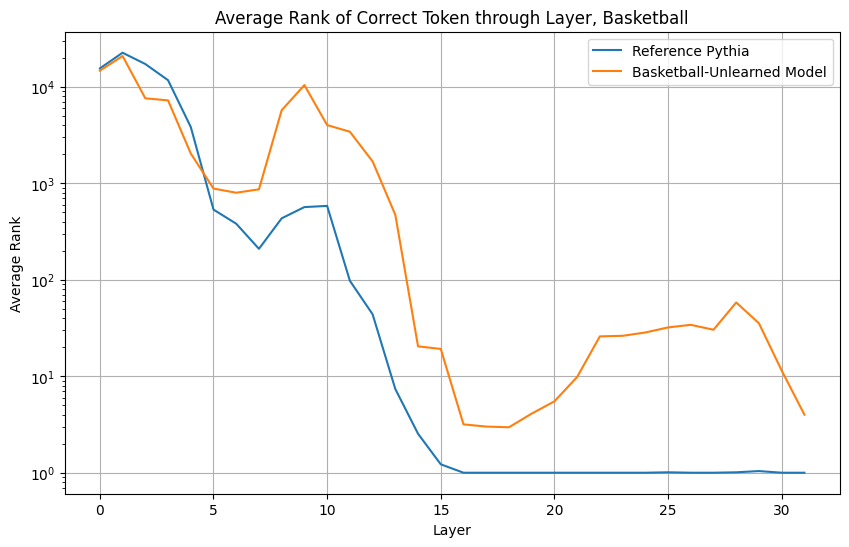

In [50]:
basketball_average_ranks = {}
for model in models:
    basketball_average_ranks[model] = []
    for layer in test_ranks_dict[model]:
        basketball_average_ranks[model].append(basketball_test_ranks_dict[model][layer].float().mean().item())
        
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(basketball_average_ranks[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Average Rank")
plt.xlabel("Layer")
plt.title("Average Rank of Correct Token through Layer, Basketball")
plt.yscale("log")
plt.show()


### Attack 3: Probability Delta

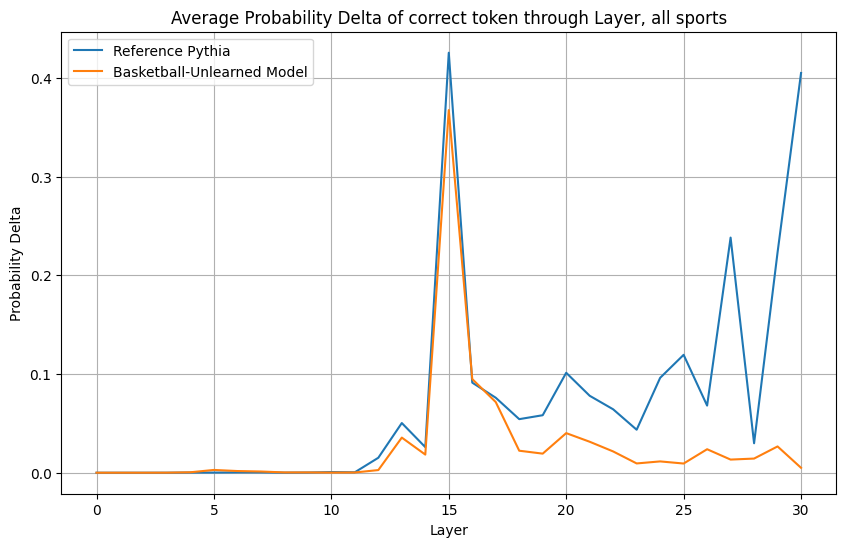

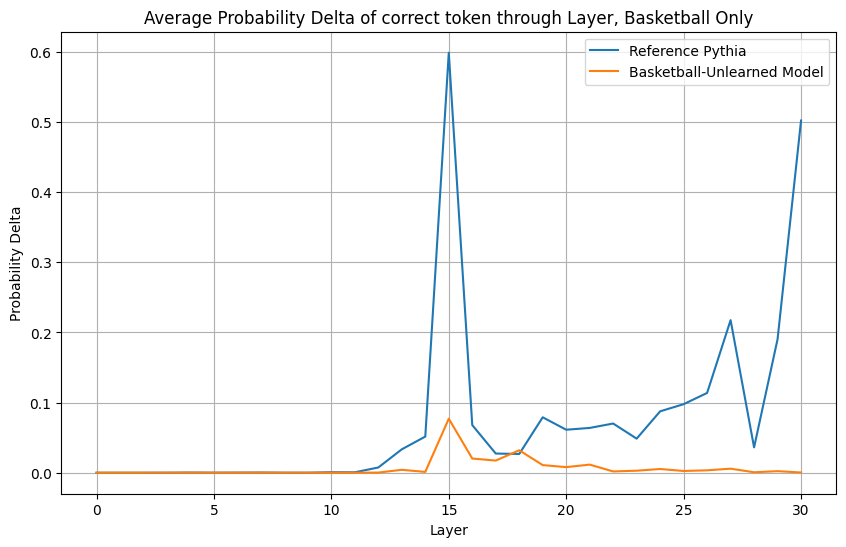

In [48]:
# get difference in token probability between successive layers
prob_delta_dict = {}
for model in models:
    prob_delta_dict[model] = {}
    for layer in range(len(test_logprobs_dict[model])-1):
        prob_delta_dict[model][layer] = (torch.exp(test_logprobs_dict[model][layer+1]) - torch.exp(test_logprobs_dict[model][layer])).abs()

# plot average delta
average_deltas = {}
for model in models:
    average_deltas[model] = []
    for layer in prob_delta_dict[model]:
        correct_deltas = prob_delta_dict[model][layer][torch.arange(len(test_labels)), test_labels]
        average_deltas[model].append(correct_deltas.mean().item())

plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(average_deltas[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Probability Delta")
plt.xlabel("Layer")
plt.title("Average Probability Delta of correct token through Layer, all sports")
plt.show()

# basketball only:
basketball_average_deltas = {}
for model in models:
    basketball_average_deltas[model] = []
    for layer in prob_delta_dict[model]:
        correct_deltas = prob_delta_dict[model][layer][basketball_indices, test_labels[basketball_indices]]
        basketball_average_deltas[model].append(correct_deltas.mean().item())
plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(basketball_average_deltas[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Probability Delta")
plt.xlabel("Layer")
plt.title("Average Probability Delta of correct token through Layer, Basketball Only")
plt.show()


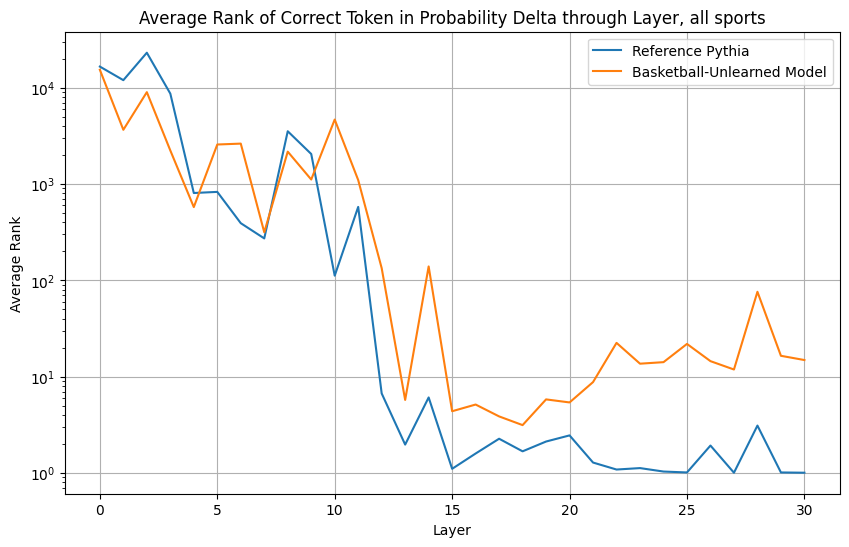

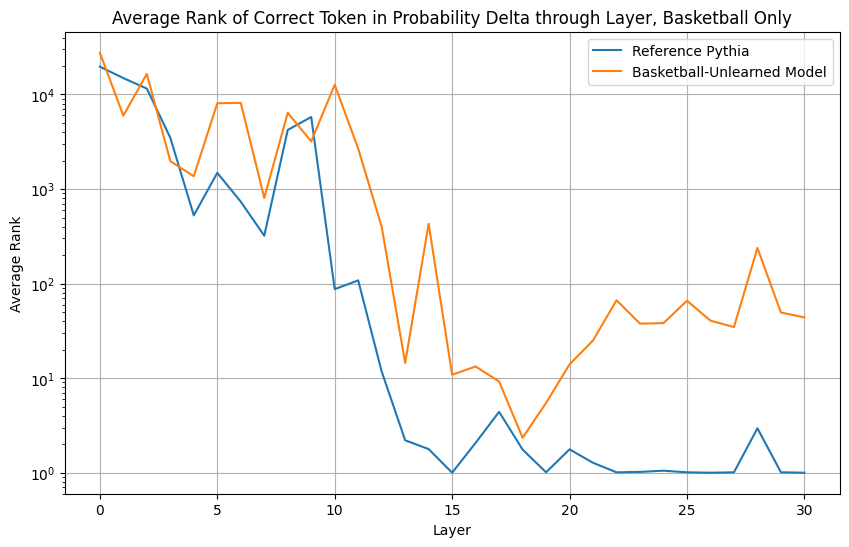

In [49]:
# Rank of correct token in probability delta
average_delta_ranks = {}
for model in models:
    average_delta_ranks[model] = []
    for layer in prob_delta_dict[model]:
        delta_ranks = get_label_rank(prob_delta_dict[model][layer], test_labels)
        average_delta_ranks[model].append(delta_ranks.float().mean().item())

plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(average_delta_ranks[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Average Rank")
plt.xlabel("Layer")
plt.title("Average Rank of Correct Token in Probability Delta through Layer, all sports")
plt.yscale("log")
plt.show()


basketball_delta_ranks = {}
for model in models:
    basketball_delta_ranks[model] = []
    for layer in prob_delta_dict[model]:
        delta_ranks = get_label_rank(prob_delta_dict[model][layer][basketball_indices], test_labels[basketball_indices])
        basketball_delta_ranks[model].append(delta_ranks.float().mean().item())

plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(basketball_delta_ranks[model], label=f"{model}")
plt.grid(True)
plt.legend()
plt.ylabel("Average Rank")
plt.xlabel("Layer")
plt.title("Average Rank of Correct Token in Probability Delta through Layer, Basketball Only")
plt.yscale("log")
plt.show()


## Probing
Train probes to detect if basketball, baseball, football are correct

In [7]:
football_token, baseball_token, basketball_token = sports_normal.get_sports_tokens(tokenizer)
def get_resids(sports_task, model):
    train_outputs = get_pythia_hf_residuals(sports_task.train_df["prompt"], model, last_token_only=True) # needs to not be last token only because of layernorm
    test_outputs = get_pythia_hf_residuals(sports_task.test_df["prompt"], model, last_token_only=True)

    football_token, baseball_token, basketball_token = sports_task.get_sports_tokens(tokenizer)
    train_labels = sports_task.train_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()
    test_labels = sports_task.test_df["sport"].apply(lambda x: {"football": football_token, "baseball": baseball_token, "basketball": basketball_token}[x]).to_numpy()

    return train_outputs, test_outputs, train_labels, test_labels


train_outputs_dict = {}
test_outputs_dict = {}
for model in models:
    train_outputs_dict[model], test_outputs_dict[model], train_labels, test_labels = get_resids(sports_normal, models[model])
test_labels = np.array(test_labels)

train_basketball_indices = (sports_normal.train_df["sport"] == "basketball").to_numpy()
test_basketball_indices = (sports_normal.test_df["sport"] == "basketball").to_numpy()


  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/1252 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

In [8]:
# train and test probes over all sports
from sklearn.linear_model import LogisticRegression

basketball_probe_train_labels = train_labels == basketball_token
basketball_test_labels = test_labels == basketball_token

baseball_probe_train_labels = train_labels == baseball_token
baseball_test_labels = test_labels == baseball_token

football_probe_train_labels = train_labels == football_token
football_test_labels = test_labels == football_token

probe_types = {"Basketball": (basketball_probe_train_labels, basketball_test_labels), 
              "Baseball": (baseball_probe_train_labels, baseball_test_labels), 
              "Football": (football_probe_train_labels, football_test_labels)}

all_probes_dict = {}
train_probe_accs = {}
test_probe_accs = {}
for model in models:
    all_probes_dict[model] = {}
    train_probe_accs[model] = {}
    test_probe_accs[model] = {}
    for probe_type in probe_types:
        all_probes_dict[model][probe_type] = []
        train_probe_accs[model][probe_type] = []
        test_probe_accs[model][probe_type] = []
        for layer in tqdm(range(len(test_outputs_dict[model]))):
            # train a probe
            probe_train_labels, probe_test_labels = probe_types[probe_type]

            probe_train_outputs = torch.cat(train_outputs_dict[model][layer], dim=0).cpu().numpy()
            probe_test_outputs = torch.cat(test_outputs_dict[model][layer], dim=0).cpu().numpy()
            
            probe = LogisticRegression(max_iter=1000).fit(probe_train_outputs, probe_train_labels)
            all_probes_dict[model][probe_type].append(probe)
            train_probe_accs[model][probe_type].append(probe.score(probe_train_outputs, probe_train_labels))
            test_probe_accs[model][probe_type].append(probe.score(probe_test_outputs, probe_test_labels))


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

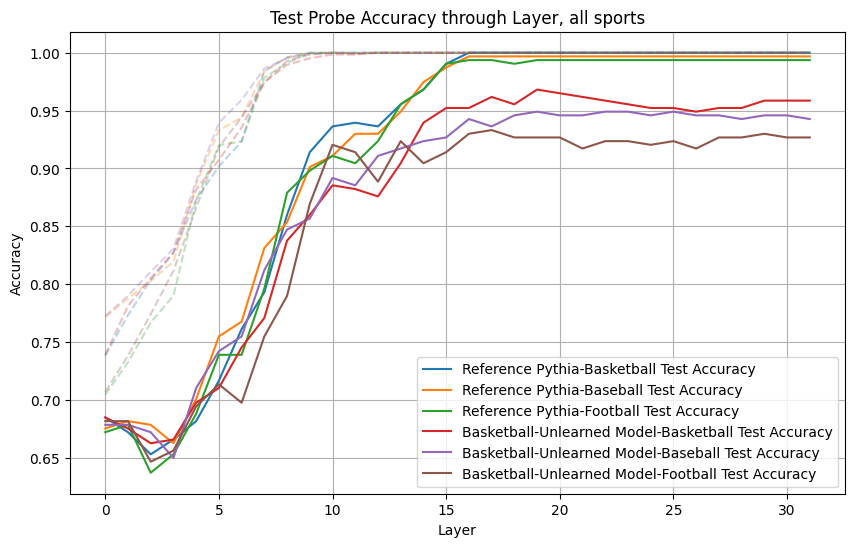

In [12]:
# plot train and test probe accs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
color_idx = 0
for model in models:
# for model in ["Reference Pythia"]:
    for probe_type in probe_types:
        plt.plot(train_probe_accs[model][probe_type], alpha=0.3, color=f'C{color_idx}', linestyle="--")
        plt.plot(test_probe_accs[model][probe_type], label=f"{model}-{probe_type} Test Accuracy", color=f'C{color_idx}')
        color_idx += 1

plt.grid(True)
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Layer")
plt.title("Test Probe Accuracy through Layer, all sports")
plt.show()
